In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [69]:
news = pd.read_csv("data/webinar_2/articles.csv")
print(news.shape)
news.head()

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [70]:
users = pd.read_csv("data/webinar_2/users_articles.csv")
print(users.shape)
users.head()

(8000, 2)


,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [71]:
from gensim.corpora.dictionary import Dictionary

In [72]:
#предобработка текстов
import re
import numpy as np
import nltk

from nltk.corpus import stopwords

#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel

import pymorphy2

In [73]:
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')
len(stopword_ru)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


151

In [74]:
morph = pymorphy2.MorphAnalyzer()

In [75]:
with open('data/webinar_2/stopwords.txt', encoding='utf-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]

In [76]:
stopword_ru = list(set(stopword_ru + additional_stopwords + ['ио', 'го']))
len(stopword_ru)

626

In [77]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', text)

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    
    text = re.sub('[a-z]', ' ', text) # добавлено замена латинских символов на пробел
    
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)    
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

In [80]:
cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-' - ранее уже было удалено в функции "clean_text"
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''
    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
#         if w[0] == '-': # [2] - не требуется, т.к. мы уже удалили все тире в функции "clean_text"
#             w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if i not in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [78]:
news['title'][0]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [81]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 19.5 s


In [82]:
news['title'][0]

'заместитель председателя правительства рф сергей иванов избран председателем совета пбк цска  как сообщает прессслужба армейцев такое решение было единогласно принято на первом заседании совета клуба основной функцией этого органа будет обсуждение текущего состояния планирование и утверждение стратегии развития клуба на ближайшую перспективу  в состав совета вошли георгий полтавченко полномочный представитель президента в центральном федеральном округе алексей седов генералполковник начальник службы по защите конституционного строя и борьбе с терроризмом фсб рф  александр новак заместитель министра финансов рф вячеслав полтавцев заместитель генерального директора руководитель блока по взаимодействию с органами власти социальной и корпоративной политики гмк норильский никель  леонид исакович генеральный директор ооо ук спортивные проекты ольга плешакова генеральный директор трансаэро  александр провоторов  генеральный директор оао ростелеком  андрей лопатов эксигрок цска чемпион мира т

In [86]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 14s


In [56]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [136]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 34.1 s


In [137]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [138]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

In [139]:
unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.16633177), (3, 0.08272039), (4, 0.22054568), (7, 0.50762)]

In [140]:
x = lda.show_topics(num_topics=25, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words
# lda.print_topics(-1)
for topic, words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: звезда египетский перевод армения пол вниз ньюйорк фотография лёд джон
topic_1: мужчина тело женщина всё обнаружить дом найти квартира убийство рассказывать
topic_2: военный армия боевой удар оборона россия советский база афганистан развивающийся
topic_3: день экипаж первый тыс около место мероприятие программа москва центр
topic_4: годовой кремль полоса тур девочка знаменитый испания сон немец франция
topic_5: ребёнок гражданин мозг женщина исследование семья организм жизнь связанный лаборатория
topic_6: научный банк наука новый данные эксперимент поверхность помощь объём университет
topic_7: всё автор очень жизнь хороший первый писать большой планета школа
topic_8: млрд оборудование бюджет космонавт рубль миллиард медицина доллар расход клинический
topic_9: производитель мышь одежда гражданство надёжный ми надпись дорого возведение извинение
topic_10: фестиваль доход достигать величина лодка фунт консультация поражать воспаление лечить
topic_11: исследование россия пациент т

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [165]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [167]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])

topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]

topic_matrix['doc_id'] = news['doc_id'].values

topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.077942,0.0,0.0,0.024748,0.000000,0.0,0.691209,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,4896,0.000000,0.0,0.0,0.000000,0.360062,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.614287,0.0,0.0,0.0
2,4897,0.166354,0.0,0.0,0.082714,0.220641,0.0,0.000000,0.507509,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,4898,0.000000,0.0,0.0,0.000000,0.086230,0.0,0.000000,0.755372,0.0,...,0.0,0.0,0.0,0.0,0.019708,0.0,0.000000,0.0,0.0,0.0
4,4899,0.162733,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


### Следующий шаг - векторные представления пользователей

In [169]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [170]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))
doc_dict[293622]

array([0.0613485 , 0.        , 0.        , 0.10351997, 0.        ,
       0.        , 0.        , 0.14938773, 0.        , 0.        ,
       0.        , 0.21833296, 0.        , 0.        , 0.04572577,
       0.        , 0.20354527, 0.10375013, 0.        , 0.        ,
       0.10265552, 0.        , 0.        , 0.        , 0.        ])

In [189]:
def get_user_embedding_mean(user_articles_list):
    
    def article_parse(user_articles_list: str) -> list:
        return list(map(int, user_articles_list.strip('[]').split(', ')))
    
#     user_articles_list = literal_eval(user_articles_list)
    user_articles_list = article_parse(user_articles_list)
    
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [196]:
def get_user_embedding_median(user_articles_list):
    
    def article_parse(user_articles_list: str) -> list:
        return list(map(int, user_articles_list.strip('[]').split(', ')))
    
#     user_articles_list = literal_eval(user_articles_list)
    user_articles_list = article_parse(user_articles_list)
    
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [197]:
def get_user_embedding_max(user_articles_list):
    
    def article_parse(user_articles_list: str) -> list:
        return list(map(int, user_articles_list.strip('[]').split(', ')))
    
#     user_articles_list = literal_eval(user_articles_list)
    user_articles_list = article_parse(user_articles_list)
    
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [203]:
user_articles_list = users['articles'][33]
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [200]:
get_user_embedding_mean(user_articles_list)

array([0.01276778, 0.09846708, 0.03940708, 0.00450909, 0.04019691,
       0.0091912 , 0.01776606, 0.035355  , 0.        , 0.00428815,
       0.00330063, 0.11928863, 0.00867831, 0.07015892, 0.31485442,
       0.        , 0.02116782, 0.11236077, 0.01351687, 0.        ,
       0.00465552, 0.02720926, 0.        , 0.01942375, 0.01090128])

In [201]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04421839, 0.        , 0.        ,
       0.        , 0.08527926, 0.        , 0.05675514, 0.29730129,
       0.        , 0.        , 0.13024316, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [202]:
get_user_embedding_max(user_articles_list)

array([0.07660665, 0.44713375, 0.18263941, 0.02705457, 0.19847934,
       0.04425203, 0.10659636, 0.07537932, 0.        , 0.02572888,
       0.01980379, 0.33264118, 0.05206987, 0.18386203, 0.75598079,
       0.        , 0.09447469, 0.21801607, 0.04772548, 0.        ,
       0.02793314, 0.16325556, 0.        , 0.11654248, 0.0456377 ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [233]:
def all_user_embeddings(users_articles, foo):
    user_embeddings = pd.DataFrame([i for i in users_articles.apply(lambda x: foo(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    return user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [234]:
user_embeddings_mean = all_user_embeddings(users['articles'], get_user_embedding_mean)
user_embeddings_mean.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.010225,0.030120,0.000000,0.175204,0.000000,0.068429,0.024882,0.024898,0.018925,...,0.000000,0.036782,0.027235,0.013410,0.012913,0.058688,0.013982,0.022003,0.037853,0.035723
1,u108690,0.005288,0.072209,0.006760,0.044069,0.003140,0.045069,0.012715,0.032763,0.002476,...,0.000000,0.025615,0.046054,0.008621,0.034991,0.076469,0.004888,0.000000,0.047869,0.000000
2,u108339,0.004214,0.075422,0.007611,0.086960,0.041278,0.025352,0.043247,0.002748,0.007040,...,0.000000,0.026735,0.048427,0.007973,0.005862,0.000000,0.047346,0.003910,0.009707,0.003874
3,u101138,0.000000,0.072707,0.015808,0.045383,0.232457,0.000000,0.012038,0.131517,0.002993,...,0.060956,0.041045,0.090525,0.001776,0.000000,0.038551,0.017693,0.008304,0.026864,0.018425
4,u108248,0.008583,0.062204,0.000000,0.076378,0.002352,0.064759,0.021681,0.014606,0.000000,...,0.000000,0.076790,0.047301,0.007371,0.002651,0.035616,0.027991,0.026323,0.008229,0.000000


In [235]:
user_embeddings_median = all_user_embeddings(users['articles'], get_user_embedding_median)
user_embeddings_median.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.0,0.172172,0.000000,0.018427,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010145,0.000000,0.000000,0.000000,0.0
1,u108690,0.000000,0.051865,0.0,0.031463,0.000000,0.027382,0.008523,0.030230,0.0,...,0.000000,0.000000,0.046248,0.0,0.010802,0.073587,0.000000,0.000000,0.057096,0.0
2,u108339,0.000000,0.052581,0.0,0.048875,0.010023,0.023946,0.035870,0.000000,0.0,...,0.000000,0.024442,0.029246,0.0,0.000000,0.000000,0.022127,0.000000,0.000000,0.0
3,u101138,0.000000,0.010132,0.0,0.000000,0.230473,0.000000,0.000000,0.159952,0.0,...,0.045553,0.000000,0.018908,0.0,0.000000,0.015870,0.000000,0.000000,0.000000,0.0
4,u108248,0.005993,0.056538,0.0,0.016299,0.000000,0.041625,0.018458,0.000000,0.0,...,0.000000,0.074889,0.056091,0.0,0.000000,0.000000,0.018150,0.008134,0.000000,0.0


In [236]:
user_embeddings_max = all_user_embeddings(users['articles'], get_user_embedding_max)
user_embeddings_max.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.061349,0.146922,0.000000,0.346260,0.000000,0.282876,0.136076,0.149388,0.113549,...,0.000000,0.203545,0.103750,0.080460,0.077479,0.229181,0.083890,0.114860,0.118382,0.123518
1,u108690,0.031730,0.217716,0.040562,0.124824,0.018842,0.170545,0.042133,0.089362,0.014857,...,0.000000,0.122729,0.089322,0.037430,0.132871,0.138075,0.015275,0.000000,0.094387,0.000000
2,u108339,0.014435,0.212338,0.045664,0.241418,0.199577,0.054131,0.110820,0.016490,0.042240,...,0.000000,0.056205,0.132167,0.027046,0.021364,0.000000,0.151951,0.023459,0.058240,0.023245
3,u101138,0.000000,0.354380,0.083051,0.272299,0.498017,0.000000,0.072225,0.232653,0.017958,...,0.182782,0.167497,0.266532,0.010659,0.000000,0.121470,0.106155,0.049824,0.115868,0.080343
4,u108248,0.021461,0.152340,0.000000,0.231886,0.014113,0.144094,0.051168,0.087636,0.000000,...,0.000000,0.195279,0.086605,0.033608,0.015905,0.213696,0.091400,0.122328,0.029038,0.000000


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [208]:
target = pd.read_csv("data/webinar_2/users_churn.csv")
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [237]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_median = pd.merge(user_embeddings_median, target, 'left')
X_max = pd.merge(user_embeddings_max, target, 'left')

In [238]:
X_mean.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.010225,0.030120,0.000000,0.175204,0.000000,0.068429,0.024882,0.024898,0.018925,...,0.036782,0.027235,0.013410,0.012913,0.058688,0.013982,0.022003,0.037853,0.035723,0
1,u108690,0.005288,0.072209,0.006760,0.044069,0.003140,0.045069,0.012715,0.032763,0.002476,...,0.025615,0.046054,0.008621,0.034991,0.076469,0.004888,0.000000,0.047869,0.000000,1
2,u108339,0.004214,0.075422,0.007611,0.086960,0.041278,0.025352,0.043247,0.002748,0.007040,...,0.026735,0.048427,0.007973,0.005862,0.000000,0.047346,0.003910,0.009707,0.003874,1
3,u101138,0.000000,0.072707,0.015808,0.045383,0.232457,0.000000,0.012038,0.131517,0.002993,...,0.041045,0.090525,0.001776,0.000000,0.038551,0.017693,0.008304,0.026864,0.018425,0
4,u108248,0.008583,0.062204,0.000000,0.076378,0.002352,0.064759,0.021681,0.014606,0.000000,...,0.076790,0.047301,0.007371,0.002651,0.035616,0.027991,0.026323,0.008229,0.000000,1


In [239]:
X_median.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.0,0.172172,0.000000,0.018427,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.010145,0.000000,0.000000,0.000000,0.0,0
1,u108690,0.000000,0.051865,0.0,0.031463,0.000000,0.027382,0.008523,0.030230,0.0,...,0.000000,0.046248,0.0,0.010802,0.073587,0.000000,0.000000,0.057096,0.0,1
2,u108339,0.000000,0.052581,0.0,0.048875,0.010023,0.023946,0.035870,0.000000,0.0,...,0.024442,0.029246,0.0,0.000000,0.000000,0.022127,0.000000,0.000000,0.0,1
3,u101138,0.000000,0.010132,0.0,0.000000,0.230473,0.000000,0.000000,0.159952,0.0,...,0.000000,0.018908,0.0,0.000000,0.015870,0.000000,0.000000,0.000000,0.0,0
4,u108248,0.005993,0.056538,0.0,0.016299,0.000000,0.041625,0.018458,0.000000,0.0,...,0.074889,0.056091,0.0,0.000000,0.000000,0.018150,0.008134,0.000000,0.0,1


In [240]:
X_max.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.061349,0.146922,0.000000,0.346260,0.000000,0.282876,0.136076,0.149388,0.113549,...,0.203545,0.103750,0.080460,0.077479,0.229181,0.083890,0.114860,0.118382,0.123518,0
1,u108690,0.031730,0.217716,0.040562,0.124824,0.018842,0.170545,0.042133,0.089362,0.014857,...,0.122729,0.089322,0.037430,0.132871,0.138075,0.015275,0.000000,0.094387,0.000000,1
2,u108339,0.014435,0.212338,0.045664,0.241418,0.199577,0.054131,0.110820,0.016490,0.042240,...,0.056205,0.132167,0.027046,0.021364,0.000000,0.151951,0.023459,0.058240,0.023245,1
3,u101138,0.000000,0.354380,0.083051,0.272299,0.498017,0.000000,0.072225,0.232653,0.017958,...,0.167497,0.266532,0.010659,0.000000,0.121470,0.106155,0.049824,0.115868,0.080343,0
4,u108248,0.021461,0.152340,0.000000,0.231886,0.014113,0.144094,0.051168,0.087636,0.000000,...,0.195279,0.086605,0.033608,0.015905,0.213696,0.091400,0.122328,0.029038,0.000000,1


In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [256]:
def logreg_fit_predict(df):
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(df[['topic_{}'.format(i) for i in range(25)]],
                                                        df['churn'], random_state=0)
    logreg = LogisticRegression()
    #обучим 
    logreg.fit(X_train, y_train)
    return y_test, logreg.predict_proba(X_test)[:, 1]

In [262]:
#наши прогнозы для тестовой выборки
y_test, preds_mean = logreg_fit_predict(X_mean)
preds_mean[:10]

array([0.12678753, 0.08633318, 0.36922067, 0.16519212, 0.04898362,
       0.03221907, 0.05974109, 0.08027787, 0.05034139, 0.11851574])

In [258]:
#наши прогнозы для тестовой выборки
y_test, preds_median = logreg_fit_predict(X_median)
preds_median[:10]

array([0.14963406, 0.02394853, 0.48955752, 0.16978536, 0.04285818,
       0.06584305, 0.04169929, 0.01603753, 0.04471383, 0.07767034])

In [259]:
#наши прогнозы для тестовой выборки
y_test, preds_max = logreg_fit_predict(X_max)
preds_max[:10]

array([0.06214529, 0.00247846, 0.65494008, 0.17856156, 0.00202604,
       0.00366829, 0.07097875, 0.00186695, 0.00523257, 0.24034718])

In [218]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [270]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix_mean = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix_mean], 
                                                                                            fscore_mean[ix_mean],
                                                                                            precision_mean[ix_mean],
                                                                                            recall_mean[ix_mean]))

Best Threshold_mean=0.260054, F-Score_mean=0.662, Precision_mean=0.619, Recall_mean=0.710


In [271]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_median = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix_median], 
                                                                                                    fscore_median[ix_median],
                                                                                                    precision_median[ix_median],
                                                                                                    recall_median[ix_median]))

Best Threshold_median=0.237772, F-Score_median=0.765, Precision_median=0.674, Recall_median=0.886


In [272]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix_max = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix_max], 
                                                                                            fscore_max[ix_max],
                                                                                            precision_max[ix_max],
                                                                                            recall_max[ix_max]))

Best Threshold_max=0.321791, F-Score_max=0.780, Precision_max=0.746, Recall_max=0.816


In [268]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1648  107]
 [  72  173]]


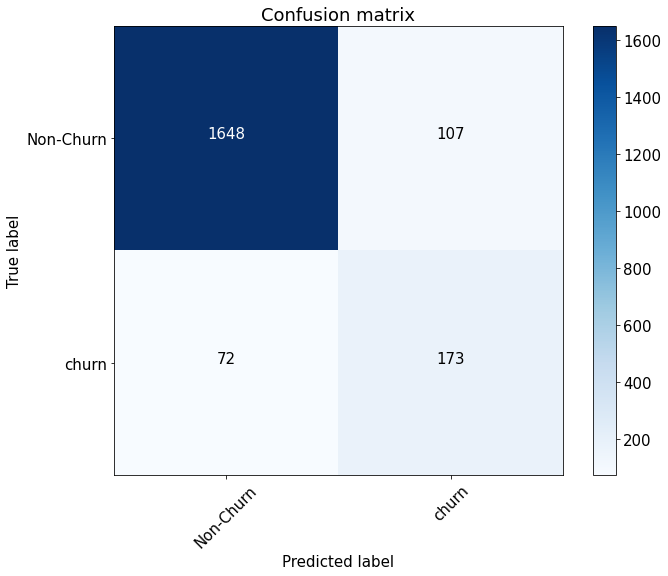

In [273]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score_mean
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_mean>thresholds_mean[ix_mean])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1650  105]
 [  29  216]]


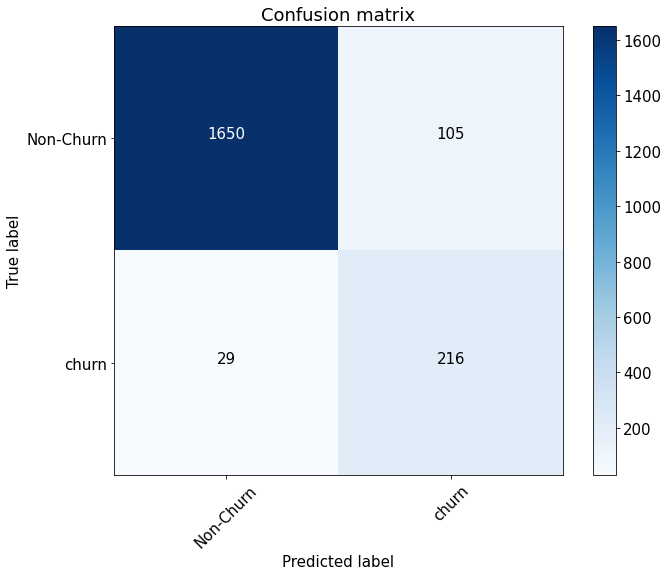

In [274]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score_median
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_median>thresholds_median[ix_median])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1687   68]
 [  46  199]]


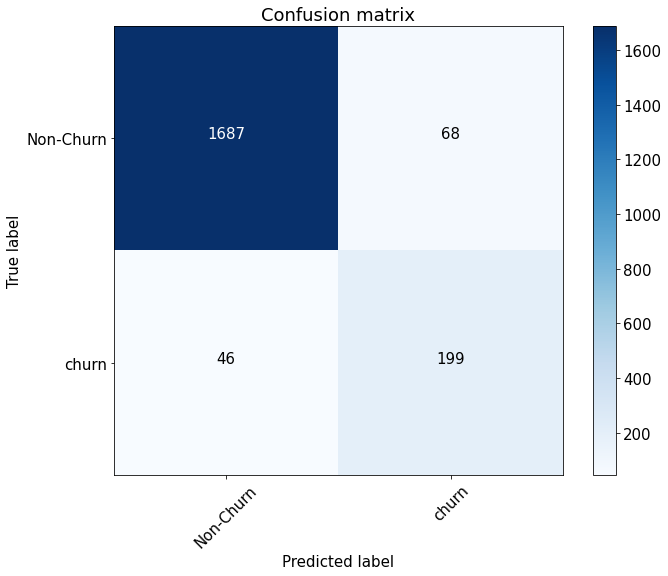

In [275]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score_max
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_max>thresholds_max[ix_max])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [251]:
roc_auc_score(y_test, preds_mean)

0.9459712773998488

In [252]:
roc_auc_score(y_test, preds_median)

0.9729635443921159

In [253]:
roc_auc_score(y_test, preds_max)

0.9694377580091865

### Выводы:

1 Добавил пару незначительных "стоп-слов" и в предобработку текстов добавил удаление латинских букв. Как ни странно f-score и ROC-AUC-score снизились.

2 Если код отрабатывает корректно, то можно заметить, что расчёт user-embeddings по медианным и максимальным значениям компонент векторов статей даёт прирось предсказательного качества модели, причем максимум f-score достигается именно при максимальных значениях компонент полученных user-embeddings, а максимум ROC-AUC-score при медианных значениях соответственно.

3 В качестве попытки трактовки полученного результата можно отметить, что медианные значения компонент векторов user-embeddings видимо статистически лучше передают интересы пользователей, т.е. содержат более сильный сигнал.
Максимальные значения компонент видимо тоже.

4 Дополнительное задание с tf-idf не делал, т.к. нужно навёрстывать пройденный материал, но видимо идея в том, чтобы id статей использовать как "слова", расчитать их вес с помощью idf и домножить на него вектора статей перед расчётом user-embeddings.